In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
%%sh
wget --quiet --output-document test.csv 'https://drive.google.com/uc?authuser=0&id=1X-jvKn6mwxmyyqFidvC2eU3GjAQyFKvx&export=download'

In [0]:
df = pd.read_csv('test.csv')
df = df.rename(columns={
    'Policy Number': 'policy_number'
})

In [0]:
df.head(10)

,policy_number,Age,Years of Driving Experience,Number of Vehicles,Gender,Married,Vehicle Age,Fuel Type,Losses
0,150023,24,5,1,M,Married,11,P,203
1,152720,31,10,1,F,Single,6,P,402
2,174207,56,37,1,M,Married,0,D,553
3,139895,52,31,1,F,Married,15,P,292
4,174407,20,3,1,M,Single,15,P,247
5,170545,29,8,1,M,Married,9,P,385
6,123164,36,19,1,F,Single,0,P,462
7,147118,67,49,1,F,Married,15,P,169
8,119842,69,48,1,M,Single,5,P,70
9,192628,16,0,1,F,Single,14,P,243


In [0]:
df.describe()

,policy_number,Age,Years of Driving Experience,Number of Vehicles,Vehicle Age,Losses
count,15290.000000,15290.000000,15290.000000,15290.000000,15290.000000,15290.000000
mean,149910.276651,42.328254,23.732897,2.495880,8.655723,389.858012
std,28948.806631,18.280511,17.850707,0.953776,4.344536,253.729469
min,100002.000000,16.000000,0.000000,1.000000,0.000000,13.000000
25%,124842.000000,24.000000,6.000000,2.000000,6.000000,226.000000
50%,149872.000000,42.000000,23.000000,2.000000,9.000000,355.000000
75%,175011.000000,61.000000,42.000000,3.000000,12.000000,489.000000
max,200000.000000,70.000000,53.000000,4.000000,15.000000,3500.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43edf4a390>]],
      dtype=object)

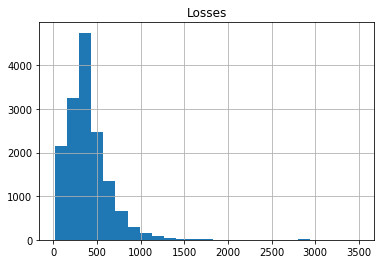

In [0]:
df.hist('Losses', bins=25)

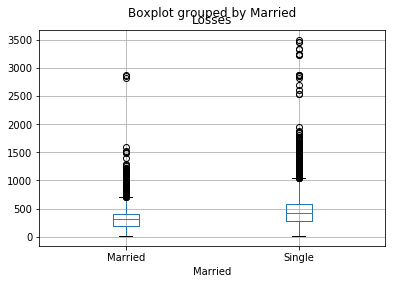

In [0]:
df.boxplot(column=['Losses'], by='Married')

In [0]:
list(df)

['policy_number',
 'Age',
 'Years of Driving Experience',
 'Number of Vehicles',
 'Gender',
 'Married',
 'Vehicle Age',
 'Fuel Type',
 'Losses']

In [0]:
x = df[(df['Losses']>= 300) & (df['Losses'] <= 340)]
x['Losses'].count()

1471

In [0]:
df['Age'].count()

15290

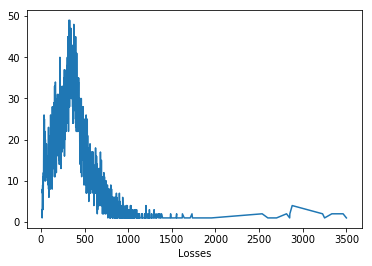

In [0]:
df.groupby(['Losses']).size().plot()

In [0]:
df = df.replace('F', 0).replace('M', 1).replace('P', 0).replace('D', 1)

In [0]:
df['Age'].corr(df['Losses'])


-0.44295052487397957

In [0]:
# 287 720
print(df.groupby('Fuel Type').size())
df[['Fuel Type', 'Losses']].groupby('Fuel Type').sum()

Fuel Type
0    11670
1     3620
dtype: int64


,Losses
Fuel Type,
0,3354466
1,2606463


,policy_number,Age,Years of Driving Experience,Number of Vehicles,Gender,Married,Vehicle Age,Fuel Type,Losses
policy_number,1,0.00066,0.0013,0.013,-0.0092,0.0051,-0.0013,0.0024,0.0046
Age,0.00066,1,1,0.0084,0.0054,-0.0043,-0.24,-0.33,-0.44
Years of Driving Experience,0.0013,1,1,0.0085,0.0074,-0.005,-0.24,-0.33,-0.44
Number of Vehicles,0.013,0.0084,0.0085,1,-0.0012,-0.0095,0.0059,-0.0034,-0.012
Gender,-0.0092,0.0054,0.0074,-0.0012,1,-0.008,-0.0035,0.17,0.18
Married,0.0051,-0.0043,-0.005,-0.0095,-0.008,1,-0.0083,-0.22,-0.27
Vehicle Age,-0.0013,-0.24,-0.24,0.0059,-0.0035,-0.0083,1,-0.29,-0.27
Fuel Type,0.0024,-0.33,-0.33,-0.0034,0.17,-0.22,-0.29,1,0.72
Losses,0.0046,-0.44,-0.44,-0.012,0.18,-0.27,-0.27,0.72,1


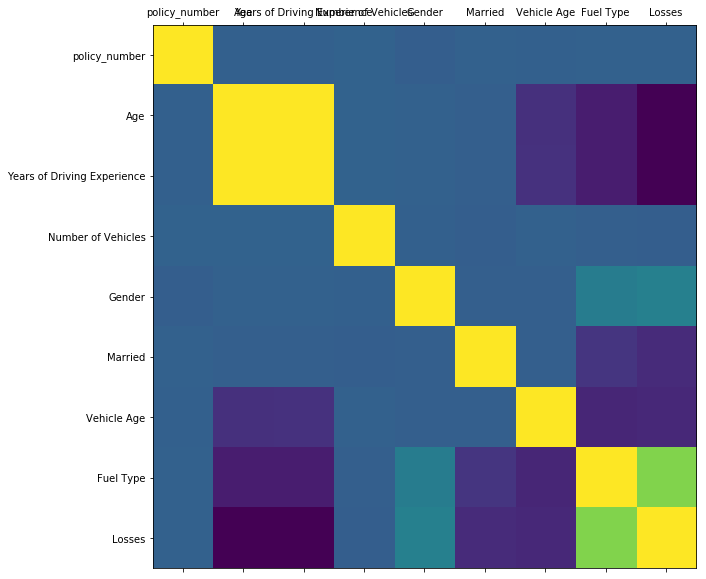

In [0]:
df = df.replace('Married', 1).replace('Single', 0)
corr = df.corr()
            
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

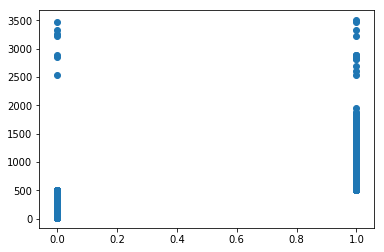

In [0]:
# plt.scatter(df['Years of Driving Experience'], df['Losses'])
# plt.scatter(df['Age'], df['Losses'])
plt.scatter(df['Fuel Type'], df['Losses'])


In [0]:
df.duplicated(['policy_number']).loc[df['policy_number'] == True]


Series([], dtype: bool)

In [0]:
df['policy_number'].duplicated().count()

In [0]:
x = df.groupby(['policy_number']).size()
len(x)

In [0]:
crashed_df = df[df.duplicated(subset=['policy_number'])]
unique_pn_array = crashed_df.policy_number.unique()
unique_pn_array

In [0]:
df.groupby('policy_number').size()

In [0]:
df[df.policy_number.isin(unique_pn_array)].sort_values('policy_number').groupby('policy_number').size().to_frame('size').sort_values('size').groupby('size').size()

In [0]:
cr = df[df.policy_number.isin(unique_pn_array)]

corr = cr.corr()
            
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [0]:
cr.boxplot(column=['Losses'], by='Married')

In [0]:
fig = plt.figure()
a = cr.boxplot(column=['Losses'], by='Vehicle Age')
b = cr.boxplot(column=['Losses'], by='Years of Driving Experience')
c = cr.boxplot(column=['Losses'], by='Gender')
d = cr.boxplot(column=['Losses'], by='Fuel Type')

a.plot()
b.plot()
c.plot()
d.plot()

In [0]:
fig, ax = plt.subplots(figsize=(8, 6))
a = cr[['Age', 'Losses']].groupby('Age').sum()
b = cr.groupby('Age').size().plot()
plt.grid()
a.plot()
plt.grid()
b.plot()



In [0]:
cr.groupby('Married').size()

In [0]:
cr.groupby('Fuel Type').size()